# Evolution of a Salesman - Genetic Algorithm for TSP

#### I have used Genetic Algorithm (GA) to find the solution to the TSP.
#### TSP can be described as:

*Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?* 

<img src="TSP.png" width = "450" height = "400" />


#### There are two important rules to keep in mind:
*1. Each city needs to be visited exactly one time*  

*2. We must return to the starting city, so our total distance needs to be calculated accordingly*

</br>

#### Approach
#### Let’s start with a few definitions, rephrased in the context of the TSP:


| Defination | Comment |
| -- | -- |
| *Gene* | A city (represented as (x, y) coordinates) |
| *Population* | A collection of possible routes (i.e., collection of individuals) |
| *Parents* | Two routes that are combined to create a new route |
| *Mating Pool* | A collection of parents that are used to create our next population (thus creating the next generation of routes) |
| *Fitness* | A function that tells us how good each route is (in our case, how short the distance is) |
| *Mutation* | A way to introduce variation in our population by randomly swapping two cities in a route |
| *Elitism* | A way to carry the best individuals into the next generation |


#### Five phases are considered in a genetic algorithm:
*1. Initial population*  

*2. Fitness function*  

*3. Selection*  

*4. Crossover*  

*5. Mutation*

*REPEAT*

## Import all the libraries

In [1]:
import numpy as np
import random
import pandas as pd
import operator
import matplotlib.pyplot as plt

## Create necessary classes and functions

### Create class to handle "cities"

In [2]:
class City:
    """
    Represents a city with coordinates (x, y) and provides methods to calculate the distance to another city.
    """

    def __init__(self, x, y):
        """
        Initialize a city with the given x and y coordinates.
        
        :param x: The x-coordinate of the city.
        :param y: The y-coordinate of the city.
        """
        self.x = x
        self.y = y
    
    def distance(self, city):
        """
        Calculate the Euclidean distance between this city and another city.

        :param city: The other city.
        :return: The distance between the two cities.
        """
        xDistance = abs(self.x - city.x)
        yDistance = abs(self.y - city.y)
        distance = np.sqrt(xDistance ** 2 + yDistance ** 2)
        return distance
    
    def __repr__(self):
        """
        Return a string representation of the city in the format (x, y).

        :return: The string representation of the city.
        """
        return "(" + str(self.x) + "," + str(self.y) + ")"

### Create a fitness function

In [3]:
class Fitness:
    """
    Represents the fitness of a route, including its distance and fitness value.
    """
    def __init__(self, route):
        """
        Initialize the Fitness object with the given route.
        
        :param route: The route to evaluate the fitness for.
        """
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def routeDistance(self):
        """
        Calculate the total distance of the route by summing the distances between consecutive cities.

        :return: The total distance of the route.
        """
        if(self.distance == 0):
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if(i + 1 < len(self.route)):
                    toCity = self.route[i+1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        """
        Calculate the fitness value of the route as the reciprocal of the route distance.
        We maximize fitness by minimizing distance. This is why we use the reciprocal of the distance.

        :return: The fitness value of the route.
        """
        if(self.fitness == 0):
            self.fitness = 1/float(self.routeDistance())
        return self.fitness

## Create our Initial Population

*- The process begins with a set of individuals which is called a Population. Each individual is a solution to the problem you want to solve.*

*- An individual is characterized by a set of parameters (variables) known as Genes. Genes are joined into a string to form a Chromosome (solution).*

*- In a genetic algorithm, the set of genes of an individual is represented using a string, in terms of an alphabet. Usually, binary values are used (string of 1s and 0s). We say that we encode the genes in a chromosome.*

<img src = "Initial Population.png" width = "450" height = "350" />

### Route generator

In [4]:
def createRoute(cityList):
    """
    Creates a random route by shuffling the given city list.
    
    :param cityList: The list of cities to create the route from.
    :return: A randomly generated route.
    """
    route = random.sample(cityList, len(cityList))
    return route

### Create first "population" (list of routes)

In [5]:
def initialPopulation(popuSize, cityList):
    """
    Initializes the population with a specified size by generating random routes.
    
    :param popuSize: The desired size of the population.
    :param cityList: The list of cities to create the routes from.
    :return: The initial population consisting of randomly generated routes.
    """
    population = []

    for i in range(0, popuSize):
        population.append(createRoute(cityList))
    return population

### Rank individuals

In [6]:
def rankRoutes(population):
    """
    Ranks the routes in the population based on their fitness values.
    
    :param population: The population of routes to be ranked.
    :return: A sorted list of tuples containing the route indices and their corresponding fitness values,
             sorted in descending order of fitness.
    """
    fitnessResults = {}
    
    for i in range(0, len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

### Create a Selection function that will be used to make the list of parent routes

*The idea of Selection phase is to select the fittest individuals and let them pass their genes to the next generation.*

*Two pairs of individuals (parents) are selected based on their fitness scores. Individuals with high fitness have more chance to be selected for reproduction.*

In [7]:
def selection(popuRanked, eliteSize):
    """
    Performs selection of individuals from the ranked population for the next generation.
    
    :param popuRanked: The ranked population, a list of tuples containing the individual indices and their fitness values.
    :param eliteSize: The number of top-ranked individuals to include in the selection.
    :return: A list of selected individual indices for the next generation.
    """
    selectionResults = []
    df = pd.DataFrame(np.array(popuRanked), columns=["Index", "Fitness"])  # Remove np.array() around popuRanked
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_prec'] = 100 * df.cum_sum / df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popuRanked[i][0])  # Append the index only
    
    for i in range(0, len(popuRanked) - eliteSize):
        pick = 100 * random.random()
        for i in range(0, len(popuRanked)):
            if pick <= df.iat[i, 3]:
                selectionResults.append(popuRanked[i][0])  # Append the index only
                break
    return selectionResults


### Create Mating pool

In [8]:
def mating(population, selectionResults):
    """
    Creates a mating pool by selecting individuals from the population based on the selection results.
    
    :param population: The population of individuals.
    :param selectionResults: The selected individual indices from the selection process.
    :return: The mating pool containing the selected individuals.
    """
    matingPool = []
    
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingPool.append(population[index])
    return matingPool

### Create a Crossover function for two parents to create one child

*Crossover is the most significant phase in a genetic algorithm. For each pair of parents to be mated, a crossover point is chosen at random from within the genes.*

</br>

*For example, consider the crossover point to be 3 as shown below.*

<img src = "Crossover 1.png" width = "450" height = "350" />

</br>
</br>
</br>

*Offspring are created by exchanging the genes of parents among themselves until the crossover point is reached.*

<img src = "Crossover 2.png" width = "450" height = "350" />

</br>
</br>
</br>

*The new offspring are added to the population.*

<img src = "Crossover 3.png" width = "450" height = "350" />

In [9]:
def breed(parent1, parent2):
    """
    Performs crossover between two parents to create a child individual.
    
    :param parent1: The first parent individual.
    :param parent2: The second parent individual.
    :return: The child individual created through crossover.
    """
    child = []
    childP1 = []
    childP2 = []
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    
    for i in range(startGene, endGene):
        childP1.append(parent1[i])
    childP2 = [item for item in parent2 if item not in childP1]
    child = childP1 + childP2
    return child

### A diagram clearly illustrating the Crossover and Mutation

<img src = "CAM.png" width = "1000" height = "350" />

### Create function to run crossover over full mating pool

In [10]:
def breedPopulation(matingPool, eliteSize):
    """
    Performs breeding (crossover) among individuals in the mating pool to create a new generation.
    
    :param matingPool: The pool of individuals selected for breeding.
    :param eliteSize: The number of top individuals to preserve as elites.
    :return: The new generation of individuals created through breeding.
    """
    children = []
    length = len(matingPool) - eliteSize
    pool = random.sample(matingPool, len(matingPool))

    for i in range(0, eliteSize):
        children.append(matingPool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingPool) - i - 1])
        children.append(child)
    return children

### Create function to mutate a single route

*In certain new offspring formed, some of their genes can be subjected to a mutation with a low random probability. This implies that some of the bits in the bit string can be flipped.*

</br>

<img src = "Mutation.png" width = "450" height = "350" />

In [11]:
def mutate(individual, mutationRate):
    """
    Applies mutation to an individual by swapping cities with a certain probability.
    
    :param individual: The individual (route) to be mutated.
    :param mutationRate: The probability of mutation for each city in the individual.
    :return: The mutated individual.
    """
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            city1 = individual[swapped]
            city2 = individual[swapWith]
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

### Create function to run mutation over entire population

In [12]:
def mutatePopulation(population, mutationRate):
    """
    Applies mutation to a population by mutating each individual in the population.
    
    :param population: The population of individuals (routes) to be mutated.
    :param mutationRate: The probability of mutation for each city in an individual.
    :return: The mutated population.
    """
    mutatedPopulation = []

    for i in range(0, len(population)):
        mutatedIndex = mutate(population[i], mutationRate)
        mutatedPopulation.append(mutatedIndex)
    return mutatedPopulation

### Put all steps together to create the next generation

In [13]:
def nextGeneration(currGeneration, eliteSize, mutationRate):
    """
    Generates the next generation of the population by performing selection, mating, breeding, and mutation.
    
    :param currGeneration: The current generation of the population.
    :param eliteSize: The number of top individuals to be preserved as elite.
    :param mutationRate: The probability of mutation for each city in an individual.
    :return: The next generation of the population.
    """
    populationRanked = rankRoutes(currGeneration)
    selectionResults = selection(populationRanked, eliteSize)
    matingPool = mating(currGeneration, selectionResults)
    children = breedPopulation(matingPool, eliteSize)
    nextGen = mutatePopulation(children, mutationRate)
    return nextGen

### Final step: create the genetic algorithm

In [14]:
def geneticAlgorithm(population, populationSize, eliteSize, mutationRate, generations):
    """
    Implements a genetic algorithm to solve the Traveling Salesman Problem (TSP).
    
    :param population: The list of cities representing the initial population.
    :param populationSize: The size of the population.
    :param eliteSize: The number of top individuals to be preserved as elite in each generation.
    :param mutationRate: The probability of mutation for each city in an individual.
    :param generations: The number of generations to run the algorithm.
    :return: The best route found by the genetic algorithm.
    """
    pop = initialPopulation(populationSize, population)
    print("Initial Distance: " + str(1/rankRoutes(pop)[0][1]))

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)

    print("Final distance: " + str(1/rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

### Create list of cities

In [15]:
"""
Empty list 'cityList' is created to store the cities.
Generates a list of 40 City objects with randomly generated coordinates within the range of (0, 0) to (99, 99) on a two-dimensional plane.
"""
cityList = []

for i in range(0, 40):
    cityList.append(City(x = int(random.random() * 100), y = int(random.random() * 100)))

### Run the Genetic Algorithm

In [16]:
"""
Runs the genetic algorithm to solve the traveling salesman problem (TSP) using a given population of cities.
"""
geneticAlgorithm(population = cityList, populationSize = 250, eliteSize = 20, mutationRate = 0.01, generations = 500)

Initial Distance: 1636.6522578834183
Final distance: 819.7096931276985


[(93,58),
 (87,35),
 (97,52),
 (99,59),
 (86,66),
 (33,73),
 (22,60),
 (25,52),
 (21,48),
 (19,49),
 (7,36),
 (16,55),
 (18,87),
 (0,99),
 (2,91),
 (1,90),
 (49,97),
 (47,79),
 (44,77),
 (59,60),
 (31,29),
 (16,48),
 (27,34),
 (36,10),
 (71,10),
 (72,2),
 (46,31),
 (60,2),
 (51,32),
 (50,37),
 (68,45),
 (65,46),
 (73,45),
 (59,70),
 (45,88),
 (84,99),
 (83,64),
 (69,78),
 (81,71),
 (84,60)]

## Plot the progress

### Note, this will win run a separate GA

In [17]:
def geneticAlgorithmPlot(population, populationSize, eliteSize, mutationRate, generations):
    """
    Allows visualizing the improvement in the best route's distance over generations, 
    providing insights into the convergence and effectiveness of the genetic algorithm in solving the TSP.
    """
    pop = initialPopulation(populationSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

### Run the function with our assumptions to see how distance has improved in each generation

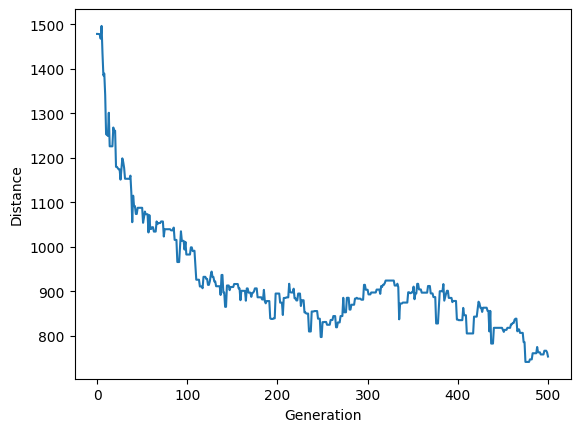

In [18]:
geneticAlgorithmPlot(population = cityList, populationSize = 250, eliteSize = 20, mutationRate = 0.01, generations = 500)

#### Well, we can see how the distance improved in each generation!!